In [1]:
import numpy as np
import math
import scipy.io as sio
import matplotlib.pyplot as  plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from scipy.stats import wilcoxon, ks_2samp, multivariate_normal
from scipy.interpolate import griddata
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
from numba import njit, prange


#### LOCAL FUNCTIONS AND CLASSES

In [2]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, c = 'tab:blue', alpha = 1, htype = 'step'):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y,s=1, color=c)

    # now determine nice limits by hand:
    binwidth = 0.2
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    print(xymax)
    lim = (np.rint((xymax+1)/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    axx = ax_histx.hist(x, bins=bins)
    ax_histx.set_ylim(0,(axx[0].max()//100+1)*100)
    axy = ax_histy.hist(y, bins=bins, orientation='horizontal')
    ax_histy.set_xlim(0,(axy[0].max()//100+1)*100)

def plot_gaussian_ellipse(mean, cov, ax, n_std=1.0, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)

def SUM_LOG_LIST(position):
    '''Given an integer n it recursively calculates log(n!)'''
    if position == 0:
        return np.array([0])
    if position == 1:
        return np.append(SUM_LOG_LIST(0), 0)
    new_list = SUM_LOG_LIST(position-1)
    return np.append(new_list, new_list[-1]+np.around(np.log(float(position)), 8))

def POISSON_2DCELL(tc_grid, max_firing=20):
    log_list = np.tile(SUM_LOG_LIST(max_firing)[:,None,None], tc_grid.shape)
    log_tc = np.around(np.log(tc_grid), 8)#, where=(mask==1), out = np.ones_like(tc_grid)*-100)
    log_likelihood = (np.array([(i*log_tc-tc_grid) for i in range(max_firing+1)])-log_list)
#     log_likelihood[0, mask==0]=0
#     log_likelihood[1:, mask==0]=-np.inf
    likelihood = np.exp(log_likelihood)
    likelihood = likelihood/np.sum(likelihood, axis=0)
    return likelihood    

    
# Define the network
class SimpleRegressor(nn.Module):
    def __init__(self):
        super(SimpleRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

#### LOAD DATA

In [3]:
mat = sio.loadmat('carlo_data.mat')
np.random.seed(10)

bases = mat['U']
imgs = mat['X']
pcs = mat['X_lowd']
fit = mat['f']
spikes = mat['r']

#### CHARACTERIZE PRIOR DISTRIBUTION OF PRINCIPAL COMPONENTS (GAUSSIAN) + PLOT

4.652305365957404


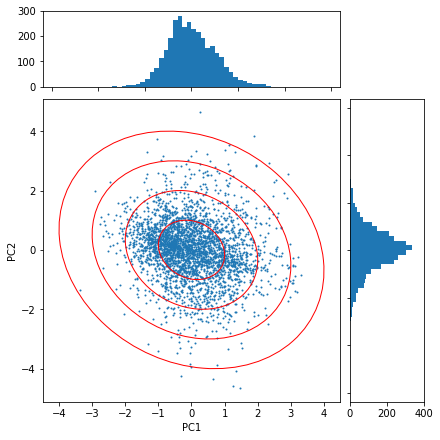

In [4]:
mu0 = pcs[0].mean()
mu1 = pcs[1].mean()
sigma = np.cov(pcs[0], pcs[1])

fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(6, 6),
                              gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 4]},
                              constrained_layout=True)

scatter_hist(pcs[0], pcs[1], axs['scatter'], axs['histx'], axs['histy'])
axs['scatter'].set_xlabel('PC1')
axs['scatter'].set_ylabel('PC2')

for n_std in np.arange(0,5, 1):
    plot_gaussian_ellipse(np.array([mu0,mu1]), sigma, \
                          axs['scatter'], n_std = n_std, edgecolor='red', facecolor='None')
# plt.show()
plt.savefig('PC_1&2_distribution_gauss.jpg', bbox_inches = 'tight')

#### NN FIT OF TC + PLOT TC AND GRADIENT

(3160,)
Epoch 1/200, Train Loss: 3.4314, Val Loss: 3.9784
Epoch 20/200, Train Loss: 1.3354, Val Loss: 1.5386
Epoch 40/200, Train Loss: 0.4442, Val Loss: 0.4372
Epoch 60/200, Train Loss: 0.2916, Val Loss: 0.2961
Epoch 80/200, Train Loss: 0.2681, Val Loss: 0.2711
Epoch 100/200, Train Loss: 0.2542, Val Loss: 0.2681
Epoch 120/200, Train Loss: 0.2482, Val Loss: 0.2675
Epoch 140/200, Train Loss: 0.2450, Val Loss: 0.2667
Epoch 160/200, Train Loss: 0.2430, Val Loss: 0.2659
Epoch 180/200, Train Loss: 0.2415, Val Loss: 0.2648
Epoch 200/200, Train Loss: 0.2402, Val Loss: 0.2639
(251001, 1)


Text(0, 0.5, 'PC2')

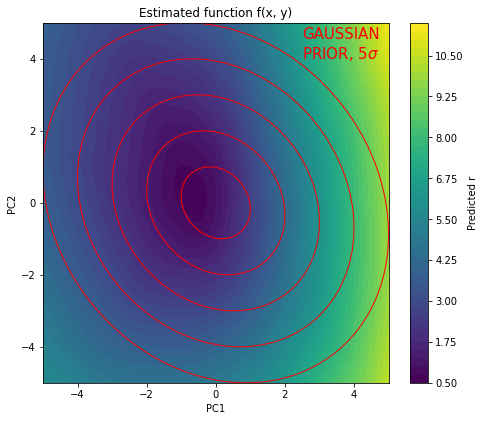

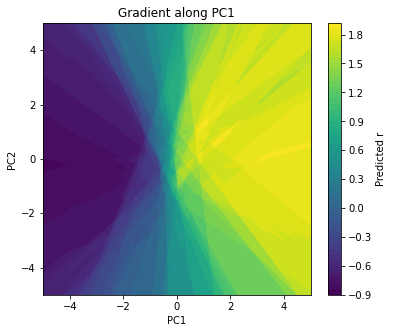

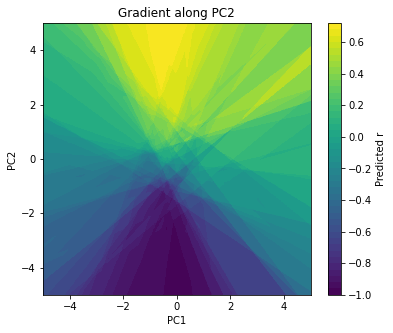

In [5]:
X = np.copy(pcs[:2]).T  # x and y
y = np.copy(np.array(fit[0]))   # r
print(y.shape)
# Optional: Normalize inputs for better training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32, requires_grad=True)
X_test  = torch.tensor(X_test_np, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
y_test  = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)


# Initialize model, loss, and optimizer
model = SimpleRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0 or epoch == 0:
        model.eval()
        val_loss = criterion(model(X_test), y_test).item()
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

# Inference: evaluate on a grid for visualization
model.eval()

#--------------------------------------------------------------------------------------
# CALCULATE GRID - THIS GRID WILL BE USED THROUGHOUT

grid_x, grid_y = np.meshgrid(np.linspace(-5, 5, 501), np.linspace(-5, 5, 501))
grid_input = np.column_stack((grid_x.ravel(), grid_y.ravel()))
grid_input_scaled = scaler.transform(grid_input)
#--------------------------------------------------------------------------------------

with torch.no_grad():
    preds = model(torch.tensor(grid_input_scaled, dtype=torch.float32)).numpy()
    print(preds.shape)
    
grad_X_tensor = torch.tensor(grid_input_scaled, dtype=torch.float32, requires_grad=True)
output = model(grad_X_tensor)
output.backward(torch.ones_like(output))
grads = grad_X_tensor.grad.detach().numpy()
grad_sq = np.sum(grads**2, axis=1)

# Plot
fig = plt.figure(figsize=(6, 5))
ax = fig.add_axes([0,0,1,1])
plt.contourf(grid_x, grid_y, preds.reshape(grid_x.shape), levels=50, cmap='viridis')

for n_std in np.arange(0,6, 1):
    plot_gaussian_ellipse(np.array([mu0,mu1]), \
                          sigma, ax, n_std = n_std, edgecolor='red', facecolor='None')
plt.text(2.5,4, 'GAUSSIAN\nPRIOR,'+r' 5$\sigma$', color = 'red', size =15)
plt.colorbar(label="Predicted r")
plt.title("Estimated function f(x, y)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-5,5)
plt.ylim(-5,5)

# plt.savefig('NN_estimated_f(x,y).jpg', bbox_inches = 'tight', dpi = 300)
# plt.show()

plt.figure(figsize=(6, 5))
plt.contourf(grid_x, grid_y, grads[:,0].reshape(grid_x.shape), levels=50, cmap='viridis')
plt.colorbar(label="Predicted r")
plt.title("Gradient along PC1")
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.show()
# plt.savefig('NN_estimated_f(x,y)_gradientPC_1.jpg', bbox_inches = 'tight', dpi = 300)


plt.figure(figsize=(6, 5))
plt.contourf(grid_x, grid_y, grads[:,1].reshape(grid_x.shape), levels=50, cmap='viridis')
plt.colorbar(label="Predicted r")
plt.title("Gradient along PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.savefig('NN_estimated_f(x,y)_gradientPC_2.jpg', bbox_inches = 'tight', dpi = 300)


#### TC AND PRIOR SUPERIMPOSED

(-5.0, 5.0)

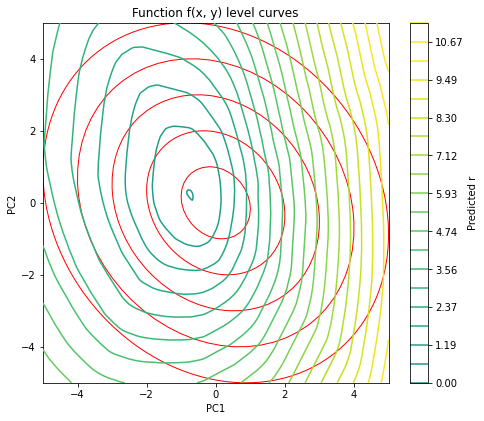

In [6]:
with torch.no_grad():
    preds = model(torch.tensor(grid_input_scaled, dtype=torch.float32)).numpy()
    
contour_levels = np.linspace(0, np.max(preds), 20)
# Plot
fig = plt.figure(figsize=(6, 5))
ax = fig.add_axes([0,0,1,1])
plt.contour(grid_x, grid_y, preds.reshape(grid_x.shape), \
            zorder = 12,vmin =-10,vmax=10, levels=contour_levels, cmap='viridis')

for n_std in np.arange(0,6, 1):
    plot_gaussian_ellipse(np.array([mu0,mu1]), \
                          sigma, ax, n_std = n_std, edgecolor='red', facecolor='None')
    
plt.colorbar(label="Predicted r")
plt.title("Function f(x, y) level curves")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-5,5)
plt.ylim(-5,5)

# plt.savefig('NN_estimated_f_level_curves.jpg', bbox_inches = 'tight', dpi=300)

#### EVALUATE NN FIT AGAINST DATA

% of datapoints w |err|>=2:  0.8860759493670887
Error mean:  -0.0032090218180117866
r2 score: 0.8419


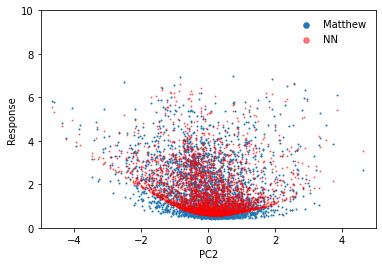

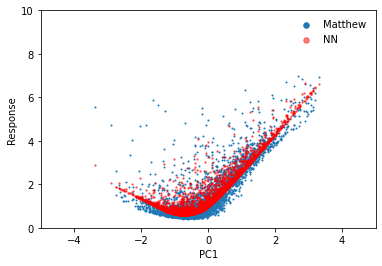

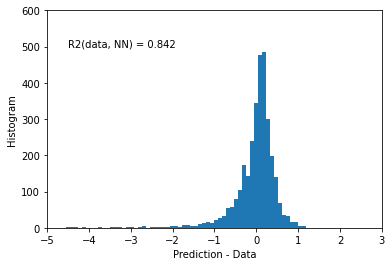

In [7]:
# x = pcs[0]
# y = pcs[1]
z = fit[0]

with torch.no_grad():
    preds = model(torch.tensor(pcs[:2].T, dtype=torch.float32)).numpy()

plt.scatter(pcs[1], fit, s=1, label = f'Matthew')
plt.scatter(pcs[1], preds[:,0], s=1, color = 'red', alpha = 0.5, label = 'NN')
plt.xlim(-5,5)
plt.ylim(0,10)
lgnd = plt.legend(frameon = False, scatterpoints = 1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.xlabel('PC2')
plt.ylabel('Response')
# plt.savefig('PC2 vs Response (Matthew & NN).jpg', bbox_inches = 'tight')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pcs[0], fit, s=1, label = f'Matthew')
ax.scatter(pcs[0], preds[:,0], s=2, color = 'red', alpha = 0.5, label = 'NN')
plt.xlim(-5,5)
plt.ylim(0,10)
ax.set_xlabel('PC1')
ax.set_ylabel('Response')
lgnd = plt.legend(frameon = False, scatterpoints = 1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
# plt.savefig('PC1 vs Response (Matthew & NN).jpg', bbox_inches = 'tight')


err =preds[:,0]-z
coefficient_of_dermination = r2_score(z, preds[:,0])

plt.figure()
plt.hist(err, bins = 60)
plt.xlabel('Prediction - Data')
plt.xlim(-5,3)
plt.ylim(0,600)
plt.ylabel('Histogram')
print("% of datapoints w |err|>=2: ",np.count_nonzero(np.abs(err)>=2)/3160*100)
print('Error mean: ', err.mean())
plt.text(-4.5,500, f'R2(data, NN) = {coefficient_of_dermination:.3f}')
print(f'r2 score: {coefficient_of_dermination:.4f}')
# plt.savefig('Error = Data-Prediction.jpg', bbox_inches = 'tight')


#### VISUALIZE PRIOR ON 501X501 MESHGRID

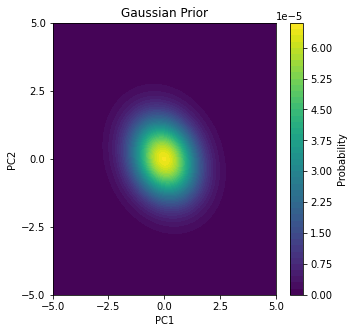

In [8]:
mus = pcs[:2].mean(axis=1)
sigma = np.cov(pcs[:2])
prior = multivariate_normal(mus, sigma)


# grid = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)
grid_prior = prior.pdf(grid_input).reshape(grid_x.shape)/prior.pdf(grid_input).reshape(grid_x.shape).sum()

plt.figure(figsize=(5, 5))
plt.contourf(grid_x, grid_y, grid_prior, levels=50, cmap='viridis')
plt.colorbar(label="Probability")
plt.title(f"Gaussian Prior")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xticks(np.arange(-5,5.1,2.5))
plt.yticks(np.arange(-5,5.1,2.5))
plt.show()


## CALCULATE LIKELIHOOD AND POSTERIOR

In [9]:
with torch.no_grad():
    preds = model(torch.tensor(grid_input, dtype=torch.float32)).numpy()[:,0]

baseline = 1e-2
tc = preds.reshape(grid_x.shape)+baseline
likelihood = POISSON_2DCELL(tc)
evidence = np.sum(likelihood*np.tile(grid_prior[None,:,:], (likelihood.shape[0],1,1)), axis=(-1,-2))
posterior = likelihood*np.tile(grid_prior[None,:,:], (likelihood.shape[0],1,1))/\
                        np.tile(evidence[:,None,None], (1,*likelihood.shape[1:])) 
posterior[posterior==0] = 1e-50
posterior = posterior/np.tile(posterior.sum(axis=(1,2))[:,None,None], (1, *grid_x.shape))

## CALCULATE PRIOR AND POSTERIOR ENTROPY AND SSI

In [10]:
post_entropy = -np.sum(posterior*np.around(np.log2(posterior),8), axis=(1,2))
prior_entropy = -np.sum(grid_prior*np.around(np.log2(grid_prior), 8))
ssi = prior_entropy - np.sum(likelihood * np.tile(post_entropy[:,None,None], (1, *grid_x.shape)) ,axis=0)

#### PLOT LIKELIHOOD p(r|X,Y), given some r, ON 501X501 GRID

([<matplotlib.axis.YTick at 0x7f4d7039ba20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

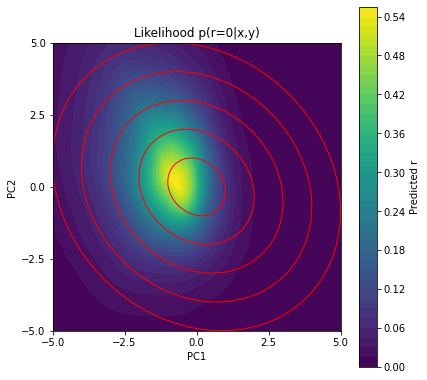

In [11]:
n_spikes = 0

fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0,0,1,1])

plt.contourf(grid_x, grid_y, likelihood[n_spikes], levels=50, cmap='viridis')
for n_std in np.arange(0,6, 1):
    plot_gaussian_ellipse(np.array([mu0,mu1]), \
                          sigma, ax, n_std = n_std, edgecolor='red', facecolor='None')
plt.axis('square')

plt.colorbar(label="Predicted r")
plt.title(f"Likelihood p(r={n_spikes}|x,y)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xticks(np.arange(-5,5.1,2.5))
plt.yticks(np.arange(-5,5.1,2.5))
# plt.savefig(f'Likelihood p(r={n_spikes}|x,y).jpg', bbox_inches = 'tight', dpi=300)

#### SANITY CHECK - PLOT EVIDENCE p(r)

0.9999999999999994


Text(0, 0.5, 'Spike probability')

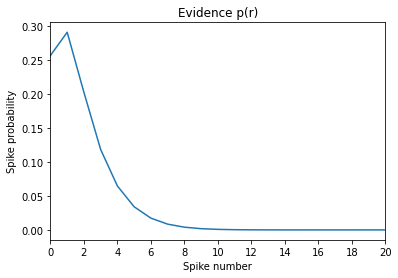

In [12]:
evidence = np.sum(likelihood*np.tile(grid_prior[None,:,:], (likelihood.shape[0],1,1)), axis=(-1,-2))
print(evidence.sum())
plt.plot(np.arange(0,21,1), evidence)
plt.xticks(np.arange(0,21,2), np.arange(0,21,2))
plt.xlim(0,20)
# plt.ylim(0,0.02)
plt.title('Evidence p(r)')
plt.xlabel('Spike number')
plt.ylabel('Spike probability')
# plt.savefig('Evidence p(r).jpg', bbox_inches = 'tight')

#### PLOT POSTERIOR p(x,y|r), given some r

(-5.0, 5.0)

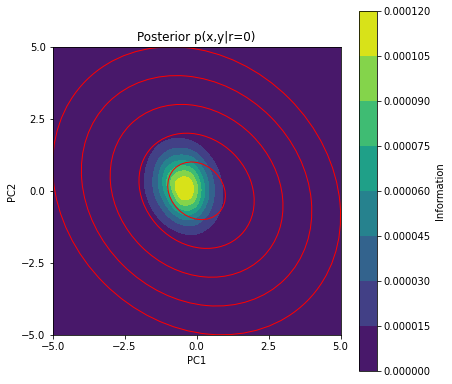

In [13]:
fig = plt.figure(figsize =(5,5))
ax = fig.add_axes([0,0,1,1])
which_r= 0
plt.title(f'Posterior p(x,y|r={which_r})')
plt.contourf(grid_x, grid_y, posterior[which_r])

for n_std in np.arange(0,6, 1):
    plot_gaussian_ellipse(np.array([mu0,mu1]), \
                          sigma, ax, n_std = n_std, edgecolor='red', facecolor='None')

plt.xticks(np.arange(-5,5.1,2.5))
plt.yticks(np.arange(-5,5.1,2.5))
plt.axis('square')
plt.colorbar(label='Information')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-5,5)
plt.ylim(-5,5)
# plt.savefig(f'p(x,y|r={which_r}).jpg', bbox_inches = 'tight', dpi=300)

## CALCULATE BAYESIAN DECODING ERROR FOR 501X501 GRID
#### -> WOULD BE GOOD TO PARALLELIZE!

In [37]:
print(posterior.shape)
mse = np.empty_like(posterior[0])
for i in range(likelihood.shape[1]):
    for j in range(likelihood.shape[2]):
#         post_ij = np.sum(prior*np.tile(likelihood[:,i,j][:,None,None], (1, *likelihood.shape[1:])), axis=0)
        post_ij = np.sum(posterior*np.tile(likelihood[:,i,j][:,None,None], (1,*likelihood.shape[1:])), axis=0)
        delta = (grid_x - grid_x[i,j])**2+(grid_y-grid_y[i,j])**2
        mse[i,j] = np.sum(post_ij*delta)
#         print(i,j)

# @njit(parallel=True, fastmath=True)
# def compute_mse(posterior, likelihood, grid_x, grid_y):
#     H, W = likelihood.shape[1], likelihood.shape[2]
#     K = posterior.shape[0]
#     mse = np.empty((H, W), dtype=np.float64)
    
#     for i in prange(H):
#         for j in range(W):
#             # compute weighted posterior for (i,j)
#             post_ij = np.zeros((H, W))
#             for k in range(K):
#                 post_ij += posterior[k] * likelihood[k, i, j]
            
#             delta = (grid_x - grid_x[i,j])**2 + (grid_y - grid_y[i,j])**2
#             mse[i,j] = np.sum(post_ij * delta)
    
#     return mse

# mse = compute_mse(posterior, likelihood, grid_x, grid_y)

rmse = np.sqrt(mse)
# np.savez('BDE.npz', mse=mse, rmse=rmse)

(21, 501, 501)
1.0
1.0000000000000002
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999999
0.9999999999999999
1.0
1.0
0.9999999999999997
1.0000000000000004
0.9999999999999999
0.9999999999999999
1.0
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999998
1.0
1.0
1.0
0.9999999999999996
0.9999999999999998
0.9999999999999998
0.9999999999999999
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
1.0
0.9999999999999998
1.0
0.9999999999999997
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999997
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999999
1.0000000000000002
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
0.99999999999999

KeyboardInterrupt: 

In [34]:
dec = np.load('BDE.npz')
mse = dec['mse']
rmse = dec['rmse']
print(mse.shape)

(501, 501)


## COMPARE SSI AND BDE -> CORRELATION

(0.389249609888863, 0.0)


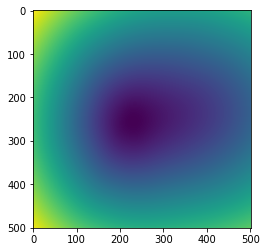

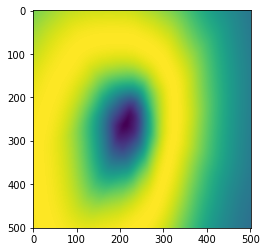

In [35]:
plt.imshow(rmse)

plt.figure()
plt.imshow(-ssi)
from scipy.stats import pearsonr, spearmanr
print(pearsonr(rmse.flatten(), -ssi.flatten()))

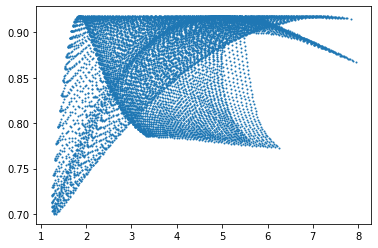

In [23]:
plt.scatter(rmse[::5,::5].flatten(), 2**(-ssi[::5,::5].flatten()), s=1)

(0.0, 10.0)

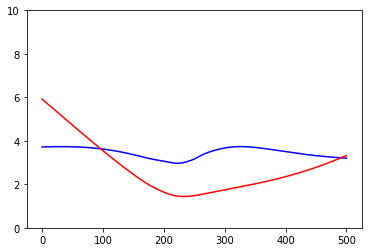

In [53]:
ssi_bound = 2**(prior_entropy-ssi-2*np.log2(50))/(np.sqrt(2*np.pi*math.e))
pos = 220
plt.plot(np.arange(501), ssi_bound[pos], color = 'b')
plt.plot(np.arange(501), rmse[pos], color = 'r')

plt.ylim(0,10)